In [52]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import soundfile as sf
import random
import json
import pandas as pd
import ffmpeg
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from glob import glob
import kagglehub
import shutil
import os
from multiprocessing import Pool, cpu_count
from torch.nn.utils.rnn import pad_sequence
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from panns_inference import AudioTagging
from panns_inference.models import Cnn14
import time
import seaborn as sns

In [5]:
import librosa
print(librosa.feature.melspectrogram)

<function melspectrogram at 0x7fd1a2d01940>


In [6]:
path = kagglehub.dataset_download("andrewmvd/covid19-cough-audio-classification")

target_dir = "data"

# Создаём папку, если её нет
os.makedirs(target_dir, exist_ok=True)

# Копируем всё содержимое
shutil.copytree(path, target_dir, dirs_exist_ok=True)

print(f"Dataset скопирован в: {target_dir}")

100%|██████████| 1.24G/1.24G [00:08<00:00, 150MB/s] 

Extracting files...


Dataset скопирован в: data


In [3]:
def generate_labels_from_json(json_folder, threshold=0.7, save_csv_path=None):
    """
    Проходит по json-файлам и формирует DataFrame с метками.

    Args:
        json_folder: путь к папке с json
        threshold: порог для классификации (обычно 0.6 или 0.7)
        save_csv_path: если задан, сохраняет метки в CSV

    Returns:
        DataFrame с колонками ['id', 'label']
    """
    data = []

    for fname in os.listdir(json_folder):
        if not fname.endswith(".json"):
            continue
        
        path = os.path.join(json_folder, fname)
        try:
            with open(path, "r") as f:
                info = json.load(f)
                cough_score = float(info.get("cough_detected", 0.0))
                label = 1 if cough_score >= threshold else 0
                file_id = os.path.splitext(fname)[0]  # без расширения
                data.append((file_id, label))
        except Exception as e:
            print(f"❌ Ошибка при обработке {fname}: {e}")
    
    df = pd.DataFrame(data, columns=["id", "label"])

    if save_csv_path:
        df.to_csv(save_csv_path, index=False)
        print(f"✅ Метки сохранены в {save_csv_path}")

    return df


In [4]:
df = generate_labels_from_json("data", threshold=0.7, save_csv_path="labels.csv")

# Посмотреть статистику классов
print(df["label"].value_counts())

✅ Метки сохранены в labels.csv
label
1    16242
0    11308
Name: count, dtype: int64


In [6]:
def convert_webm_to_wav(input_path, output_path):
    try:
        ffmpeg.input(input_path).output(output_path, ac=1, ar=16000).overwrite_output().run(quiet=True)
        return True
    except ffmpeg.Error as e:
        print(f"FFmpeg error: {e}")
        return False


def preprocess_for_cnn(audio_path, sr=16000, n_mels=64, hop_length=256):
    y, sr = librosa.load(audio_path, sr=sr)
    if len(y) == 0:
        raise ValueError("Пустой аудиофайл")
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    if np.isnan(mel_spec).any():
        raise ValueError("Mel spectrogram содержит NaN")
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    log_mel_spec_norm = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min() + 1e-6)
    return log_mel_spec_norm[np.newaxis, :, :]


def preprocess_for_lstm(audio_path, sr=16000, n_mfcc=40, hop_length=256):
    y, sr = librosa.load(audio_path, sr=sr)
    if len(y) == 0:
        raise ValueError("Пустой аудиофайл")
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    if np.isnan(mfcc).any():
        raise ValueError("MFCC содержит NaN")
    mfcc_norm = (mfcc - mfcc.min()) / (mfcc.max() - mfcc.min() + 1e-6)
    return mfcc_norm.T


def process_single_sample(args):
    uid, label, webm_dir, temp_wav_dir, output_dir_cnn, output_dir_lstm, cleanup = args
    webm_path = os.path.join(webm_dir, uid + ".webm")
    wav_path = os.path.join(temp_wav_dir, uid + ".wav")

    if not os.path.exists(webm_path):
        # print(f"⚠️ Пропущен {uid}: нет .webm файла")
        return None

    success = convert_webm_to_wav(webm_path, wav_path)
    if not success:
        return None

    try:
        cnn_tensor = preprocess_for_cnn(wav_path)
        lstm_tensor = preprocess_for_lstm(wav_path)
    except Exception as e:
        # print(f"⚠️ Ошибка при обработке {uid}: {e}")
        return None

    cnn_out_path = os.path.join(output_dir_cnn, f"{uid}_{label}.npy")
    lstm_out_path = os.path.join(output_dir_lstm, f"{uid}_{label}.npy")

    np.save(cnn_out_path, cnn_tensor)
    np.save(lstm_out_path, lstm_tensor)

    if cleanup:
        os.remove(wav_path)

    return (cnn_out_path, lstm_out_path, label)


def build_preprocessed_dataset_dual(
    webm_dir, labels_csv, output_dir_cnn, output_dir_lstm, temp_wav_dir='temp_wavs', cleanup=True
):
    os.makedirs(output_dir_cnn, exist_ok=True)
    os.makedirs(output_dir_lstm, exist_ok=True)
    os.makedirs(temp_wav_dir, exist_ok=True)

    df = pd.read_csv(labels_csv)
    args_list = [
        (row['id'], row['label'], webm_dir, temp_wav_dir, output_dir_cnn, output_dir_lstm, cleanup)
        for _, row in df.iterrows()
    ]

    cpu_to_use = max(1, cpu_count() // 2)
    print(f"🧠 Используется {cpu_to_use} потоков из {cpu_count()} доступных ядер")

    cnn_paths, lstm_paths, labels = [], [], []
    with Pool(cpu_to_use) as pool:
        for result in tqdm(pool.imap_unordered(process_single_sample, args_list), total=len(args_list)):
            if result is not None:
                cnn_path, lstm_path, label = result
                cnn_paths.append(cnn_path)
                lstm_paths.append(lstm_path)
                labels.append(label)

    pd.DataFrame({"path": cnn_paths, "label": labels}).to_csv(os.path.join(output_dir_cnn, "processed_labels.csv"), index=False)
    pd.DataFrame({"path": lstm_paths, "label": labels}).to_csv(os.path.join(output_dir_lstm, "processed_labels.csv"), index=False)

    print("✅ Все аудиофайлы успешно обработаны параллельно для CNN и LSTM.")

In [7]:
build_preprocessed_dataset_dual(
    webm_dir="data",
    labels_csv="labels.csv",
    output_dir_cnn="processed_cnn",
    output_dir_lstm="processed_lstm"
)

🧠 Используется 8 потоков из 16 доступных ядер


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27550/27550 [24:50<00:00, 18.49it/s]


✅ Все аудиофайлы успешно обработаны параллельно для CNN и LSTM.


In [16]:
BATCH_SIZE = 32
NUM_EPOCHS = 20
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
class SimpleAudioCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))  # 💡 Гарантирует размер (B,32,8,8)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))     # -> (B,16,H/2,W/2)
        x = self.pool(F.relu(self.conv2(x)))     # -> (B,32,H/4,W/4)
        x = self.adaptive_pool(x)                # -> (B,32,8,8)
        x = torch.flatten(x, 1)                  # -> (B, 32*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [2]:
class AudioDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        file_path, label = self.data_list[idx]
        data = np.load(file_path)
    
        # Убедимся, что данные имеют форму (1, FREQ, TIME)
        if data.ndim == 2:
            data = np.expand_dims(data, axis=0)  # Добавим канал
    
        data_tensor = torch.tensor(data, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return data_tensor, label_tensor


In [3]:
# Построим список (путь, метка)
def load_data_list(processed_dir):
    data_list = []
    for path in glob(os.path.join(processed_dir, "*.npy")):
        filename = os.path.basename(path)
        if "_" not in filename:
            continue
        label_str = filename.split("_")[-1].split(".")[0]
        label = int(label_str)
        data_list.append((path, label))
    return data_list

In [4]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_samples += x.size(0)
    return total_loss / total_samples, total_correct / total_samples

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += x.size(0)
    return total_loss / total_samples, total_correct / total_samples

In [5]:
def collate_fn(batch):
    tensors = [item[0] for item in batch]  # список тензоров (1, freq, time)
    labels = torch.tensor([item[1] for item in batch])

    # Найти максимальную длину по времени
    max_len = max(t.shape[2] for t in tensors)

    # Паддим все тензоры до max_len нулями по времени
    padded_tensors = []
    for t in tensors:
        pad_len = max_len - t.shape[2]
        if pad_len > 0:
            # pad (0, pad_len) - значит добавить справа вдоль последнего измерения
            padded = F.pad(t, (0, pad_len))
        else:
            padded = t
        padded_tensors.append(padded)

    batch_tensors = torch.stack(padded_tensors)
    return batch_tensors, labels


In [13]:
class MemoryAudioLSTM(nn.Module):
    def __init__(self, input_freq_dim=40, lstm_input_size=40, hidden_size=128, num_layers=3, n_classes=10, bidirectional=True):
        super().__init__()
        self.freq_reducer = nn.Linear(input_freq_dim, lstm_input_size)
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.3
        )
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), n_classes)

    def forward(self, x):  # x: (batch, time, freq)
        if x.dim() == 4:
            x = x.squeeze(1)  # Убираем лишнюю размерность, если вдруг (B, 1, T, F)
        # print("Input shape to forward:", x.shape)  # должно быть (batch, time, freq)
        x = self.freq_reducer(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [14]:
def collate_fn_lstm(batch):
    xs = [torch.tensor(item[0], dtype=torch.float32).squeeze() for item in batch]
    ys = torch.tensor([item[1] for item in batch], dtype=torch.long)

    # Паддинг по time (размерность 0)
    xs_padded = pad_sequence(xs, batch_first=True, padding_value=0.0)  # (batch, max_time, freq)

    return xs_padded, ys

In [33]:
MODEL_TYPE = "cnn"  # или "cnn"
PROCESSED_DIR = "processed_lstm" if MODEL_TYPE == "lstm" else "processed_cnn"

data_list = load_data_list(PROCESSED_DIR)
train_list, val_list = train_test_split(data_list, test_size=0.2, random_state=42)

train_dataset = AudioDataset(train_list)
val_dataset = AudioDataset(val_list)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn)

n_classes = len(set(label for _, label in data_list))

if MODEL_TYPE == "cnn":
    model = SimpleAudioCNN(n_classes=n_classes).to(DEVICE)
else:
    model = MemoryAudioLSTM(n_classes=n_classes).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [28]:
best_val_acc = 0.0
for epoch in tqdm(range(NUM_EPOCHS), desc="Обучение"):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"best_audio_{MODEL_TYPE}.pth")

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

print(f"✅ Обучение {MODEL_TYPE.upper()} завершено. "
      f"Лучшая модель сохранена в best_audio_{MODEL_TYPE}.pth")


Обучение:   5%|████████████▋                                                                                                                                                                                                                                                | 1/20 [01:03<20:07, 63.57s/it]

Epoch 1: Train Loss=0.2949, Acc=0.8752 | Val Loss=0.3115, Acc=0.8584


Обучение:  10%|█████████████████████████▎                                                                                                                                                                                                                                   | 2/20 [02:08<19:20, 64.45s/it]

Epoch 2: Train Loss=0.2820, Acc=0.8807 | Val Loss=0.2926, Acc=0.8713


Обучение:  15%|█████████████████████████████████████▉                                                                                                                                                                                                                       | 3/20 [03:12<18:09, 64.08s/it]

Epoch 3: Train Loss=0.2728, Acc=0.8850 | Val Loss=0.2704, Acc=0.8840


Обучение:  20%|██████████████████████████████████████████████████▌                                                                                                                                                                                                          | 4/20 [04:19<17:27, 65.46s/it]

Epoch 4: Train Loss=0.2643, Acc=0.8864 | Val Loss=0.2707, Acc=0.8878


Обучение:  25%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                             | 5/20 [05:20<15:54, 63.61s/it]

Epoch 5: Train Loss=0.2600, Acc=0.8914 | Val Loss=0.2580, Acc=0.8946


Обучение:  30%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                 | 6/20 [06:20<14:36, 62.64s/it]

Epoch 6: Train Loss=0.2517, Acc=0.8934 | Val Loss=0.2502, Acc=0.8959


Обучение:  35%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 7/20 [07:19<13:18, 61.40s/it]

Epoch 7: Train Loss=0.2478, Acc=0.8941 | Val Loss=0.2522, Acc=0.8978


Обучение:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 8/20 [08:22<12:22, 61.87s/it]

Epoch 8: Train Loss=0.2502, Acc=0.8952 | Val Loss=0.2572, Acc=0.8921


Обучение:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 9/20 [09:25<11:22, 62.06s/it]

Epoch 9: Train Loss=0.2438, Acc=0.8977 | Val Loss=0.2420, Acc=0.9005


Обучение:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 10/20 [10:31<10:34, 63.43s/it]

Epoch 10: Train Loss=0.2404, Acc=0.8998 | Val Loss=0.2642, Acc=0.8899


Обучение:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 11/20 [11:31<09:21, 62.38s/it]

Epoch 11: Train Loss=0.2391, Acc=0.8976 | Val Loss=0.2571, Acc=0.8913


Обучение:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 12/20 [12:31<08:12, 61.59s/it]

Epoch 12: Train Loss=0.2359, Acc=0.9012 | Val Loss=0.2603, Acc=0.8971


Обучение:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 13/20 [13:35<07:16, 62.36s/it]

Epoch 13: Train Loss=0.2351, Acc=0.9025 | Val Loss=0.2554, Acc=0.8924


Обучение:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 14/20 [14:37<06:13, 62.31s/it]

Epoch 14: Train Loss=0.2384, Acc=0.8990 | Val Loss=0.2961, Acc=0.8838


Обучение:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 15/20 [15:38<05:09, 61.81s/it]

Epoch 15: Train Loss=0.2378, Acc=0.8987 | Val Loss=0.2424, Acc=0.8997


Обучение:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 16/20 [16:47<04:15, 63.92s/it]

Epoch 16: Train Loss=0.2349, Acc=0.9008 | Val Loss=0.2543, Acc=0.8928


Обучение:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 17/20 [17:47<03:08, 62.96s/it]

Epoch 17: Train Loss=0.2319, Acc=0.9024 | Val Loss=0.2457, Acc=0.9003


Обучение:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 18/20 [18:51<02:06, 63.08s/it]

Epoch 18: Train Loss=0.2330, Acc=0.9026 | Val Loss=0.2504, Acc=0.8921


Обучение:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 19/20 [19:46<01:00, 60.63s/it]

Epoch 19: Train Loss=0.2294, Acc=0.9032 | Val Loss=0.2592, Acc=0.8913


Обучение: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [20:47<00:00, 62.40s/it]

Epoch 20: Train Loss=0.2288, Acc=0.9039 | Val Loss=0.2603, Acc=0.8928
✅ Обучение CNN завершено. Лучшая модель сохранена в best_audio_cnn.pth


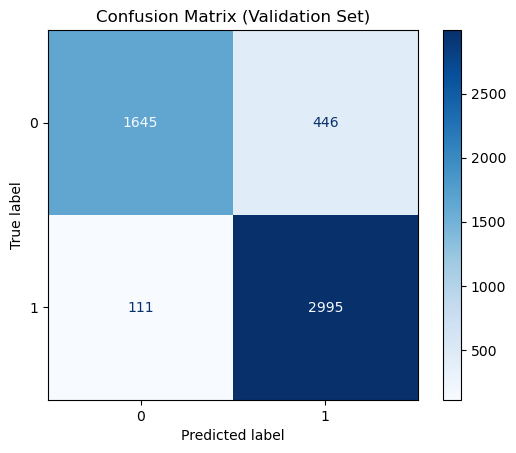

In [29]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        outputs = model(x)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# Матрица ошибок
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Validation Set)")
plt.show()

In [17]:
MODEL_TYPE = "lstm"  # или "cnn"
PROCESSED_DIR = "processed_lstm" if MODEL_TYPE == "lstm" else "processed_cnn"

data_list = load_data_list(PROCESSED_DIR)
train_list, val_list = train_test_split(data_list, test_size=0.2, random_state=42)

train_dataset = AudioDataset(train_list)
val_dataset = AudioDataset(val_list)

if MODEL_TYPE == "cnn":
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn)
else:
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn_lstm)
    val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn_lstm)

n_classes = len(set(label for _, label in data_list))

if MODEL_TYPE == "cnn":
    model_2 = SimpleAudioCNN(n_classes=n_classes).to(DEVICE)
else:
    model_2 = MemoryAudioLSTM(n_classes=n_classes).to(DEVICE)

optimizer = torch.optim.AdamW(model_2.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [18]:
best_val_acc = 0.0
for epoch in tqdm(range(NUM_EPOCHS), desc="Обучение"):
    train_loss, train_acc = train(model_2, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = evaluate(model_2, val_loader, criterion, DEVICE)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_2.state_dict(), f"best_audio_{MODEL_TYPE}.pth")

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

print(f"✅ Обучение {MODEL_TYPE.upper()} завершено. "
      f"Лучшая модель сохранена в best_audio_{MODEL_TYPE}.pth")


Обучение:   0%|                                                                                                                                                                                                                                                                     | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_9982/148902708.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs = [torch.tensor(item[0], dtype=torch.float32).squeeze() for item in batch]
Обучение:   0%|                                                                                                                                                                                                                                                                     | 0/20 [00:06<?, ?it/s]


KeyboardInterrupt: 

/tmp/ipykernel_10279/148902708.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs = [torch.tensor(item[0], dtype=torch.float32).squeeze() for item in batch]


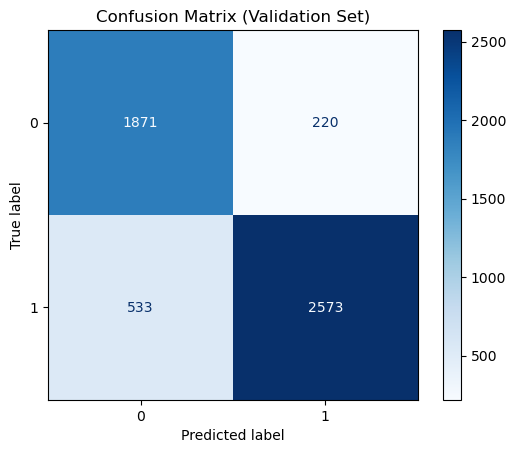

In [70]:
all_preds = []
all_labels = []

model_2.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        outputs = model_2(x)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# Матрица ошибок
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Validation Set)")
plt.show()

### Трансформер показал похожие цифры со сверткой, но оченьние занимает в 3 раза большще времени.

In [24]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [25]:
def load_features_and_labels_fixed_len(file_label_pairs, max_len=200):
    X = []
    y = []

    for path, label in file_label_pairs:
        try:
            features = np.load(path)  # (time, n_mfcc)
            if features.shape[0] > max_len:
                features = features[:max_len, :]
            else:
                pad_width = max_len - features.shape[0]
                features = np.pad(features, ((0, pad_width), (0,0)), mode='constant')
            X.append(features.flatten())
            y.append(label)
        except Exception as e:
            print(f"Ошибка при обработке {path}: {e}")

    return np.array(X), np.array(y)

In [20]:
X_train, y_train = load_features_and_labels_fixed_len(train_list, max_len=200)
print("X_train shape:", X_train.shape)
print("Size in MB:", X_train.nbytes / 1024**2)


X_train shape: (20788, 8000)
Size in MB: 634.3994140625


In [21]:
X_val, y_val = load_features_and_labels_fixed_len(val_list, max_len=200)
print("X_val shape:", X_val.shape)
print("Size in MB:", X_val.nbytes / 1024**2)

X_val shape: (5197, 8000)
Size in MB: 158.599853515625


In [22]:
print("X_train shape:", np.shape(X_train))
print("y_train shape:", np.shape(y_train))
print("X_train shape:", np.shape(X_val))
print("y_train shape:", np.shape(y_val))

X_train shape: (20788, 8000)
y_train shape: (20788,)
X_train shape: (5197, 8000)
y_train shape: (5197,)


RandomForest results:
               precision    recall  f1-score   support

           0       0.84      0.67      0.75      2091
           1       0.80      0.91      0.86      3106

    accuracy                           0.82      5197
   macro avg       0.82      0.79      0.80      5197
weighted avg       0.82      0.82      0.81      5197



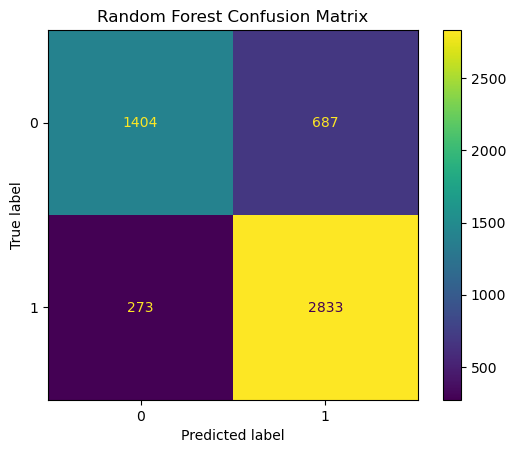

/home/saatarko/anaconda3/envs/myenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:45:21] WARNING: /croot/xgboost-split_1749630910898/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost results:
               precision    recall  f1-score   support

           0       0.82      0.72      0.76      2091
           1       0.82      0.89      0.86      3106

    accuracy                           0.82      5197
   macro avg       0.82      0.81      0.81      5197
weighted avg       0.82      0.82      0.82      5197



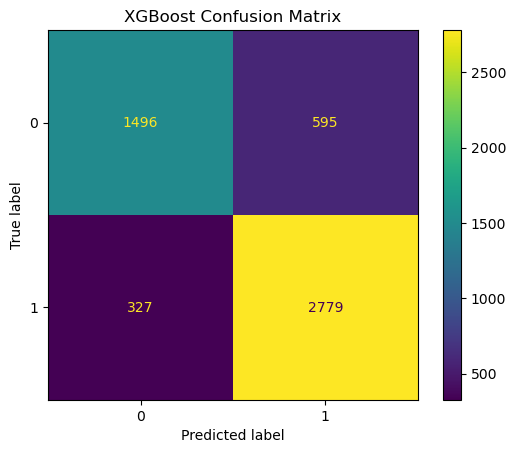

In [26]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
print("RandomForest results:\n", classification_report(y_val, y_pred_rf))

ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_rf)).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

# XGBoost
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
print("XGBoost results:\n", classification_report(y_val, y_pred_xgb))

ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_xgb)).plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 2  # изменить при необходимости
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4


In [34]:
# ==== Dataset ====
class NPYDataset(Dataset):
    def __init__(self, file_label_list):
        self.data = file_label_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        x = np.load(path)  # (1, mel, time)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(label)

# ==== Модель ====
class PANNFinetune(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.base = base_model
        self.classifier = nn.Linear(2048, num_classes)  # Выход Cnn14

    def forward(self, x):
        with torch.no_grad():
            features = self.base.forward(x, None)['embedding']
        return self.classifier(features)

In [44]:
def pad_collate(batch):
    """Batch: список из (tensor, label)"""
    tensors, labels = zip(*batch)
    
    # Найти максимальную длину
    max_len = max(tensor.shape[2] for tensor in tensors)

    # Паддинг
    padded_tensors = []
    for tensor in tensors:
        pad_len = max_len - tensor.shape[2]
        padded_tensor = F.pad(tensor, (0, pad_len), mode='constant', value=0)
        padded_tensors.append(padded_tensor)

    return torch.stack(padded_tensors), torch.tensor(labels)

In [45]:
train_dataset = NPYDataset(train_list)
val_dataset = NPYDataset(val_list)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=pad_collate)

In [48]:

optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

start_time = time.time()
for epoch in tqdm(range(EPOCHS), desc="Обучение"):
    loss, acc = train(model, train_loader, optimizer, loss_fn, device)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

total_time = time.time() - start_time
print(f"⏱️ Training took {total_time/60:.2f} minutes")




Обучение:  10%|█████████████████████████▎                                                                                                                                                                                                                                   | 1/10 [00:55<08:23, 55.99s/it]

Epoch 1/10, Loss: 0.2041, Accuracy: 0.9133


Обучение:  20%|██████████████████████████████████████████████████▌                                                                                                                                                                                                          | 2/10 [01:51<07:25, 55.66s/it]

Epoch 2/10, Loss: 0.1991, Accuracy: 0.9151


Обучение:  30%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                 | 3/10 [02:52<06:47, 58.27s/it]

Epoch 3/10, Loss: 0.1928, Accuracy: 0.9199


Обучение:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 4/10 [03:47<05:42, 57.01s/it]

Epoch 4/10, Loss: 0.1885, Accuracy: 0.9181


Обучение:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 5/10 [04:44<04:44, 56.90s/it]

Epoch 5/10, Loss: 0.1844, Accuracy: 0.9236


Обучение:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 6/10 [05:41<03:47, 56.83s/it]

Epoch 6/10, Loss: 0.1788, Accuracy: 0.9244


Обучение:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 7/10 [06:39<02:51, 57.25s/it]

Epoch 7/10, Loss: 0.1751, Accuracy: 0.9240


Обучение:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 8/10 [07:36<01:54, 57.05s/it]

Epoch 8/10, Loss: 0.1694, Accuracy: 0.9279


Обучение:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 9/10 [08:31<00:56, 56.66s/it]

Epoch 9/10, Loss: 0.1657, Accuracy: 0.9307


Обучение: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:29<00:00, 56.98s/it]

Epoch 10/10, Loss: 0.1614, Accuracy: 0.9320
⏱️ Training took 9.50 minutes


In [50]:
def evaluate_pred(model, dataloader, loss_fn, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(y.cpu().numpy())

    return y_pred, y_true


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      2091
           1       0.90      0.95      0.93      3106

    accuracy                           0.91      5197
   macro avg       0.91      0.90      0.90      5197
weighted avg       0.91      0.91      0.91      5197



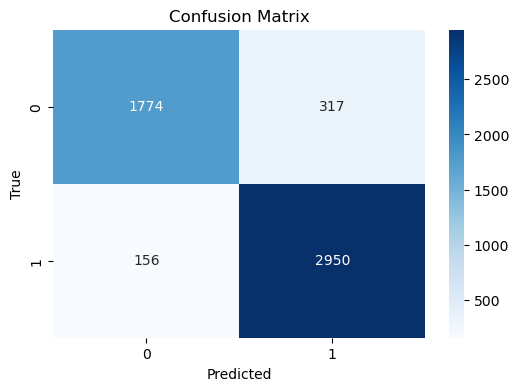

In [53]:
# ==== Оценка ====
y_pred, y_true = evaluate_pred(model, val_loader, criterion, device)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# ==== Матрица ошибок ====
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

| Модель                      | Точность | Время обучения | Комментарии                                    |
|----------------------------|----------|----------------|-----------------------------------------------|
| Простая CNN (свёртка)       | 0.89     | 30 минут       | Лучший баланс точности и простоты подготовки  |
| LSTM + attention            | 0.85     | ~3 часа        | Длинное обучение, требуется нормализация и паддинг |
| RandomForestClassifier      | 0.82     | 10 минут       | Быстрое обучение, но точность ниже CNN        |
| XGBClassifier              | 0.82     | 10 минут       | Аналогично RandomForest, чуть сложнее настройка |
| Предобученная CNN (PANNs)  | 0.91     | 20 минут       | Лучший результат по точности, быстрое обучение|


# Выводы: свертка выдает более высокие результаты, преообученная модель чтуьв ыше по точности и чуть быстрее. Но требуется подстройка под структуру данных